In [10]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable             Type              Data/Info
------------------------------------------------
Tsam                 float             0.75
dvMathcalP           LinearIOSystem    <LinearIOSystem>: sys[81]<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP          LinearIOSystem    <LinearIOSystem>: sys[80]<...> [0. 0.]\n     [0. 0.]]\n
extMathcalPcl        LinearIOSystem    <LinearIOSystem>: sys[17]<...> [0. 0.]\n     [0. 0.]]\n
fullOrder            int               80
hsvDvMathcalP        ndarray           80: 80 elems, type `float64`, 640 bytes
hsvExtMathcalP       ndarray           80: 80 elems, type `float64`, 640 bytes
mathcalC             StateSpace        A = [[-100.]]\n\nB = [[1.<...>[[-8.]]\n\nD = [[0.08]]\n
mathcalP_cb          LinearIOSystem    <LinearIOSystem>: sys[4]\<...>[[0. 0.]\n     [0. 0.]]\n
overlineMathcalC     StateSpace        A = [[-0.]]\n\nB = [[0.1]<...>= [[0.08]]\n\ndt = 0.75\n
reducOrder           int               5
truncDvMathcalP      LinearIOSystem    <LinearI

In [11]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

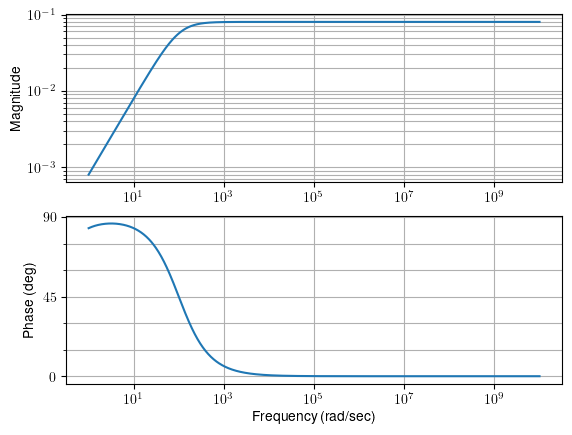

In [12]:
# Create 2nd order low-pass filter
Kp = 80e-6
Td = 10e0
N = 1.0e3

# num =  [ (Kp/Td) * N * (N + Td), (Kp/Td) * N * (1.0/Td) ]
# den = [ 1, N/Td ]
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]

mathcalC = control.tf2ss(num,den)

# Plot freq response
wLims = numpy.array([1e0, 1e10])
control.bode_plot(mathcalC, omega_limits=wLims, deg=True, wrap_phase=True)
plt.show()

<IPython.core.display.Math object>

TransferFunction(array([ 0.08, -0.08]), array([1., 0.]), 0.75)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TransferFunction(array([0.08 , 0.008]), array([  1., 100.]))

<IPython.core.display.Math object>

TransferFunction(array([-8.]), array([  1., 100.]))

<IPython.core.display.Math object>

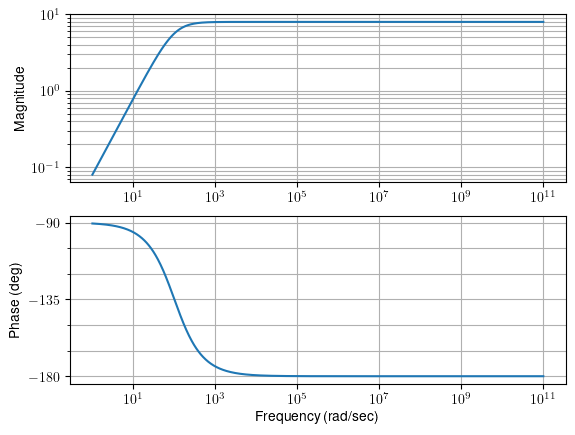

In [13]:
# Discretizing Controller
Tsam = 750.0e-3
overlineMathcalC = control.tf2ss(control.sample_system(control.ss2tf(mathcalC), Tsam, 'zoh'))
display(Math('\\overline{\\mathcal{C}} = '), control.ss2tf(overlineMathcalC))
display(Math('eigs(\\overline{A_c}) = '), sympy.Matrix(numpy.linalg.eigvals(overlineMathcalC.A)))

# Creating mathcalCPrime and cumputing norm of tildeMathcalC
mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
tfMathcalCPrime = control.ss2tf(mathcalCPrime)
display(Math('\\mathcal{C} = '), control.ss2tf(mathcalC))
display(Math('\\mathcal{C}^{\\prime} = '), tfMathcalCPrime)

# Inf norm of Delta operator
normInfDelta = 2*Tsam/numpy.pi
s = control.TransferFunction.s
# Norm widetildeMathcalC s
normInfWidetildeMathcalCs = normInfDelta * ControlUtils.hinfnorm(mathcalC) \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime) * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime) * normInfDelta 
display(Math('\\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' + str(normInfWidetildeMathcalCs)))

wLims = numpy.array([10e-1, 10e10])
# print(control.zeros(s*tfMathcalCPrime))
# print(control.poles(s*tfMathcalCPrime))
control.bode_plot(s*tfMathcalCPrime, omega_limits=wLims, deg=True, wrap_phase=True)
plt.show()

In [14]:
# Creating closed-loop

# Controller matrices
Ac = mathcalC.A
Bv = mathcalC.B
Cw = mathcalC.C
Dw = mathcalC.D

#######################################################################

# FOM extended plant
Ap = extMathcalP.A
Bw = extMathcalP.B[:,0:1]
Bu = extMathcalP.B[:,1:2]
Cv = extMathcalP.C[0:1,:]
Cy = extMathcalP.C[-1:,:]
Dv = extMathcalP.D[0:1,:]
Dy = extMathcalP.D[-1:,:]

# Closed-loop with FOM Extended Plant
extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                              numpy.column_stack( [ Bv@Cv, Ac ] )
                            ] )
extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                              numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                            ] )
extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                              numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                              numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                            ] )
extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                              numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                              numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                            ] )
extMathcalPcl = control.ss( extAcl, extBcl, extCcl, extDcl )

# L2 gain
normInfClExtMathcalP = ControlUtils.hinfnorm(extMathcalPcl)
display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfClExtMathcalP)))

# Small-gain condition
display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
    + str(normInfClExtMathcalP*normInfWidetildeMathcalCs) ))

#######################################################################

# ROM extended plant
truncExtAp = truncExtMathcalP.A
truncExtBw = truncExtMathcalP.B[:,0:1]
truncExtBu = truncExtMathcalP.B[:,1:2]
truncExtCv = truncExtMathcalP.C[0:1,:]
truncExtCy = truncExtMathcalP.C[-1:,:]
truncExtDv = truncExtMathcalP.D[0:1,:]
truncExtDy = truncExtMathcalP.D[-1:,:]

# Closed-loop with ROM Extended Plant
truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                              numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                            ] )
truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                              numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                            ] )
truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                              numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                              numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                            ] )
truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                              numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                              numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                            ] )
truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)

# L2 gain
normInfTruncExtMathcalPcl = ControlUtils.hinfnorm(truncExtMathcalPcl)
display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalPcl)))

# Small-gain condition
display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
    + str(normInfTruncExtMathcalPcl*normInfWidetildeMathcalCs) ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
# Small-gain stability condition computation
approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl

gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
gamma_dv_tildew = normInfWidetildeMathcalCs

small_gain_argument_FOM = gamma_tildew_dv*gamma_dv_tildew
display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} \\leq ' \
    + str(small_gain_argument_FOM) ))

small_gain_argument_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew
display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} \\leq ' \
    + str(small_gain_argument_ROM) ))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
# # Performance output error bound

# # Freq response continuous-time closed-loop FOM
# freq = numpy.logspace(1,6,2000)
# control.bode_plot(extMathcalPcl[0,0], freq)
# control.bode_plot(extMathcalPcl[1,0], freq)
# control.bode_plot(extMathcalPcl[2,0], freq)
# control.bode_plot(extMathcalPcl[0,1], freq)
# control.bode_plot(extMathcalPcl[1,1], freq)
# control.bode_plot(extMathcalPcl[2,1], freq)
# plt.show()

# # L2-gains FOM
# gamma_tildew_v = ControlUtils.hinfnorm(extMathcalPcl[0,0])
# gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
# gamma_tildew_y = ControlUtils.hinfnorm(extMathcalPcl[2,0])
# gamma_u_v = ControlUtils.hinfnorm(extMathcalPcl[0,1])
# gamma_u_dv = ControlUtils.hinfnorm(extMathcalPcl[1,1])
# gamma_u_y = ControlUtils.hinfnorm(extMathcalPcl[2,1])

# #######################################################################

# # Freq response continuous-time closed-loop ROM
# freq = numpy.logspace(1,6,2000)
# control.bode_plot(truncExtMathcalPcl[0,0], freq)
# control.bode_plot(truncExtMathcalPcl[1,0], freq)
# control.bode_plot(truncExtMathcalPcl[2,0], freq)
# control.bode_plot(truncExtMathcalPcl[0,1], freq)
# control.bode_plot(truncExtMathcalPcl[1,1], freq)
# control.bode_plot(truncExtMathcalPcl[2,1], freq)
# plt.show()

# # L2-gains ROM
# hat_gamma_tildew_v = ControlUtils.hinfnorm(truncExtMathcalPcl[0,0])
# hat_gamma_tildew_dv = ControlUtils.hinfnorm(truncExtMathcalPcl[1,0])
# hat_gamma_tildew_y = ControlUtils.hinfnorm(truncExtMathcalPcl[2,0])
# hat_gamma_u_v = ControlUtils.hinfnorm(truncExtMathcalPcl[0,1])
# hat_gamma_u_dv = ControlUtils.hinfnorm(truncExtMathcalPcl[1,1])
# hat_gamma_u_y = ControlUtils.hinfnorm(truncExtMathcalPcl[2,1])

# #######################################################################

# # Transfer function of continuous-time truncation error systems
# approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl

# freq = numpy.logspace(1,6,2000)
# control.bode_plot(approxErrorExtMathcalPcl[0,0], freq)
# control.bode_plot(approxErrorExtMathcalPcl[1,0], freq)
# control.bode_plot(approxErrorExtMathcalPcl[2,0], freq)
# control.bode_plot(approxErrorExtMathcalPcl[0,1], freq)
# control.bode_plot(approxErrorExtMathcalPcl[1,1], freq)
# control.bode_plot(approxErrorExtMathcalPcl[2,1], freq)
# plt.show()

# # L2-norms approximation errors
# epsilon_tildew_v = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[0,0])
# epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
# epsilon_tildew_y = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[2,0])
# epsilon_u_v = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[0,1])
# epsilon_u_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,1])
# epsilon_u_y = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[2,1])

# #######################################################################

# gamma_dv_tildew = normInfWidetildeMathcalCs
# approxError_y_bound = ( hat_gamma_tildew_y/(1-gamma_dv_tildew*hat_gamma_tildew_dv) ) \
#                                 *( ( (gamma_dv_tildew**2 * gamma_u_dv)/(1-gamma_dv_tildew*gamma_tildew_dv) )*epsilon_tildew_dv + epsilon_u_dv ) \
#                         + ( (gamma_dv_tildew * gamma_u_dv)/(1-gamma_dv_tildew*gamma_tildew_dv) )*epsilon_tildew_y + epsilon_u_y 

In [17]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = numpy.arange(-5, 5, 0.25)
# Y = numpy.arange(-5, 5, 0.25)
# X, Y = numpy.meshgrid(X, Y)
# R = numpy.sqrt(X**2 + Y**2)
# Z = numpy.sin(R)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=mpl.cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(mpl.ticker.LinearLocator(5))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

In [18]:
%store -d mathcalC overlineMathcalC Tsam extMathcalPcl truncExtMathcalPcl
%store mathcalC overlineMathcalC Tsam extMathcalPcl truncExtMathcalPcl

Stored 'mathcalC' (StateSpace)
Stored 'overlineMathcalC' (StateSpace)
Stored 'Tsam' (float)
Stored 'extMathcalPcl' (LinearIOSystem)
Stored 'truncExtMathcalPcl' (LinearIOSystem)
